In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score

In [2]:
df = pd.read_csv('i4talent.csv')

In [3]:
df['datum'] = pd.to_datetime(df['datum'])
df['geboortedatum'] = pd.to_datetime(df['geboortedatum'])
df['indiensttreding_datum'] = pd.to_datetime(df['indiensttreding_datum'])
df['WerknemerID'] = df['WerknemerID'].astype(str)
df['klant_id'] = df['klant_id'].astype(str) 

In [4]:
df['leeftijd'] = round((df['datum'] -  df['geboortedatum']) / np.timedelta64(1, 'Y'),1)
df['lengte_dienst'] = round((df['datum'] -  df['indiensttreding_datum']) / np.timedelta64(1, 'Y'),1)
df['stad'] = df['stad'].fillna('Onbekend')
df['afdeling'] = df['afdeling'].fillna('Onbekend')

In [5]:
df_sorted = df.sort_values(['WerknemerID','datum'], axis=0)
df_sorted.drop(columns=['datum','geboortedatum','indiensttreding_datum','uitdiensttreding_datum','uitdiensttreding_reden','uitdiensttreding_type','geslacht_id','STATUS_JAAR'],inplace=True)

In [6]:
df_sorted.drop_duplicates('WerknemerID', keep = 'last', inplace = True)
df_sorted = df_sorted.reset_index(drop = True)
df_sorted.drop('WerknemerID', axis = 1, inplace = True)

In [7]:
df_sorted['STATUS'] = df_sorted['STATUS'] == 'Beëindigd'
df_sorted['BUSINESS_UNIT'] = df_sorted['BUSINESS_UNIT'] == 'Intern'
df_sorted['geslacht'] = df_sorted['geslacht'] == 'Man'

In [8]:
df_model = pd.get_dummies(df_sorted)
df_model.head()

,leeftijd,lengte_dienst,geslacht,STATUS,BUSINESS_UNIT,stad_Alblasserdam,stad_Almere,stad_Alphen aan den Rijn,stad_Amstelveen,stad_Amsterdam,...,klant_id_42,klant_id_43,klant_id_44,klant_id_45,klant_id_46,klant_id_5,klant_id_6,klant_id_7,klant_id_8,klant_id_9
0,62.0,26.3,True,False,True,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,59.0,26.3,False,False,True,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,61.0,26.3,False,False,True,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,57.0,26.3,True,False,True,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,58.0,26.3,True,False,True,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## XGBClassifier

In [9]:
def print_confusion_matrix(y_test, y_predicted):
    cm = confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(5,5))
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

In [10]:
train_ratio = 0.65
test_ratio = 0.20
validation_ratio = 0.15

In [11]:
Y = np.array(df_model['STATUS'])
X = np.array(df_model.drop('STATUS', axis = 1))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=1 - train_ratio)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

In [12]:
model = XGBClassifier(objective = 'binary:logistic', 
                      min_child_weight = 1,
                      max_depth = 25,
                      learning_rate = 0.20,
                      scale_pos_weight = 4,
                      verbosity = 0, n_jobs = -1)
model.fit(X_train, y_train,
          early_stopping_rounds = 20,
          verbose=0,
          eval_metric='auc',
          eval_set=[(X_val, y_val)])

C:\Users\joach\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=25,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

C:\Users\joach\Anaconda3\lib\site-packages\xgboost\core.py:104: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


Precision: 98.87%, Recall: 94.58%, F1: 96.68%


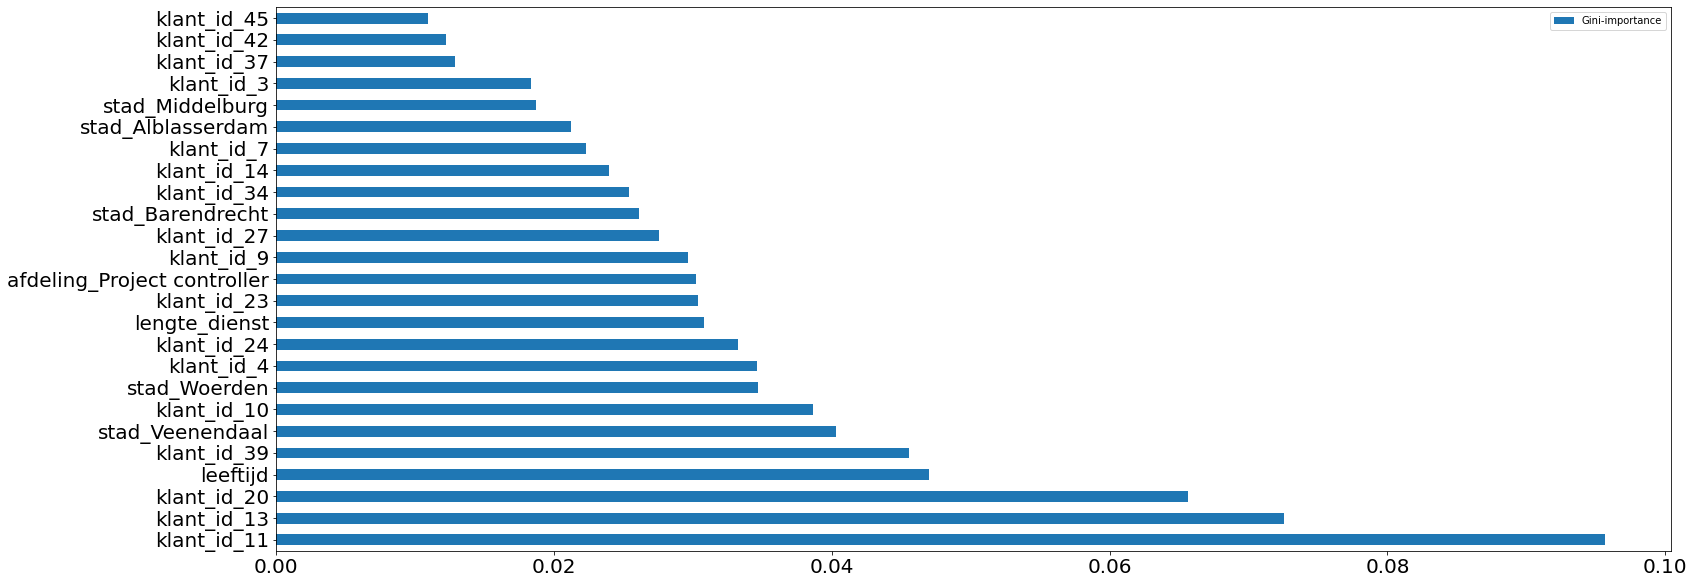

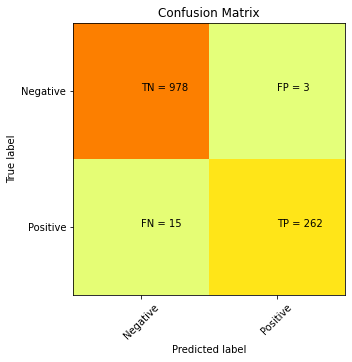

In [13]:
y_pred = model.predict(X_test, ntree_limit = 5)
predictions = [value for value in y_pred]

precision = precision_score(y_test, predictions, average='binary', pos_label = 1)
recall = recall_score(y_test, predictions, average='binary', pos_label = 1)
f1 = f1_score(y_test, predictions, average='binary', pos_label = 1)

print("Precision: %.2f%%, Recall: %.2f%%, F1: %.2f%%" % ((precision * 100.0), (recall * 100.0), (f1 * 100.0)))

feats = {} 
for feature, importance in zip(df_model.drop('STATUS', axis = 1).columns, model.feature_importances_):
    feats[feature] = importance 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance',ascending = False)[:25].plot(kind='barh',figsize=(25, 10),fontsize=20)

print_confusion_matrix(y_test, predictions)